<a href="https://colab.research.google.com/github/zp2226/E4511-2021-Zhanbo/blob/main/%E2%80%9C%E2%80%9CDRD2_EDA%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. For homework, you will work on this entire notebook for your own targets. Download your target related data from the following databases:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

## Install packages

In [3]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-04-28 02:09:25--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M  98.5MB/s    in 6.0s    

2021-04-28 02:09:31 (85.0 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigat

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge
    bravado-core-5.17.0        |     pyh9f0ad1d_0          48 KB  co

In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import io

In [5]:

!pip install molvs
!pip install bravado
!pip install umap

  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18120 sha256=2f116442a0815d3cdf97daaaac5748f9223bdfc74c7a50121e12d994eb2e6790
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339
  Created wheel for umap: filename=umap-0.1.1-cp37-none-any.whl size=3568 sha256=10e4ae8173d4cc6629c28e6e9307c3e29fca698c0b7c4b90ed7f7f26f3fef83e
  Stored in directory: /root/.cache/pip/wheels/7b/29/33/b4d917dc95f69c0a060e2ab012d95e15db9ed4cc0b94ccac26
Successfully built umap


In [6]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

## Download/Load data

In [7]:
! wget https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/Data/ChEMBL_DRD2.csv
! wget https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/Data/DTC_DRD2.csv
! wget https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/Data/ExcapeDB.csv

--2021-04-28 02:17:39--  https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/Data/ChEMBL_DRD2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12300313 (12M) [text/plain]
Saving to: ‘ChEMBL_DRD2.csv’

ChEMBL_DRD2.csv     100%[===================>]  11.73M  39.0MB/s    in 0.3s    

2021-04-28 02:17:40 (39.0 MB/s) - ‘ChEMBL_DRD2.csv’ saved [12300313/12300313]

--2021-04-28 02:17:40--  https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/Data/DTC_DRD2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71308

In [8]:
dtc = pd.read_csv("DTC_DRD2.csv", sep=',', header=0 )
excape = pd.read_csv("ExcapeDB.csv", sep=',', header=0)
chembl = pd.read_csv("ChEMBL_DRD2.csv", sep=';', header=0 )


In [16]:
dtc.iloc[1:3,1:10]

,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id
1,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,1840645.0
2,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,2531826.0


In [17]:
excape.iloc[1:3, 1:15]

,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
1,CHEMBL1834261,1813,A,5.24,chembl20,771231,9606,DRD2,1171,N1(CCN(CC1)CCCCC=2C=CC(=CC2)OC)CC=3OC=4C(C3)=C...
2,2409129,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,O=C(/C=C/1\N(C=2C(C1(C)C)=CC=CC2)C)COC3=CC(NC(...


In [18]:
chembl.iloc[1:3, 1:10]

,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation
1,NaN,0,414.59,0,4.71,BDBM107548,CCC(C)C(=O)N[C@H]1CC[C@H](CCN2CCC(c3cccc4c3OCO...,Ki,'='
2,NaN,0,380.52,0,4.15,16a,c1ccc(Nc2nc(CN3CCOCC3)nc3sc4c(c23)CCCC4)cc1,pKb,'='


# Examine data
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- Think about how we might combine these data sources together

In [9]:
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces
dtc.columns = dtc.columns.str.replace(' ','_') # get rid of annoying spaces
excape.columns = excape.columns.str.replace(' ','_') # get rid of annoying spaces


print(chembl.shape)
print(dtc.shape)
print(excape.shape)

(20833, 45)
(17590, 33)
(76636, 11)


In [10]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL3697972,NaN,0,429.56,0,2.64,BDBM121475,O=C(CC1COC1)N[C@H]1CC[C@H](CCN2CCN(c3cccc4c3OC...,Ki,'=',105.93,nM,6.97,NaN,250041,UO_0000065,16.24,0.31,4.33,11.02,False,CHEMBL3707837,Radioligand Binding Assay: Aliquots of membran...,B,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3639169,37,BindingDB Database,NaN,2014.0,None,NaN
1,CHEMBL3664863,NaN,0,414.59,0,4.71,BDBM107548,CCC(C)C(=O)N[C@H]1CC[C@H](CCN2CCC(c3cccc4c3OCO...,Ki,'=',351.61,nM,6.45,NaN,227177,UO_0000065,15.57,0.29,1.74,12.70,False,CHEMBL3707825,Biochemical Assay: The ability of the compound...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,EBNA,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3638396,37,BindingDB Database,NaN,2013.0,None,NaN
2,CHEMBL4564928,NaN,0,380.52,0,4.15,16a,c1ccc(Nc2nc(CN3CCOCC3)nc3sc4c(c23)CCCC4)cc1,pKb,'=',4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4309244,Displacement of [3H]Raclopride from recombinan...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4308833,1,Scientific Literature,J Med Chem,2018.0,None,NaN
3,CHEMBL3318846,NaN,0,945.98,2,9.36,19,O=C(CCN1CCN(CCC(=O)OC2(c3ccc(Cl)cc3)CCN(CCCC(=...,Ki,'=',1.10,nM,8.96,NaN,NaN,UO_0000065,9.47,0.19,-0.40,8.99,False,CHEMBL3369122,Displacement of [3H]spiperone from human D2sho...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3352709,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3308072,NaN
4,CHEMBL3322998,NaN,0,428.54,0,3.21,12,O=C(NCCCCN1CCN(c2ccnc3ccccc23)CC1)c1cn2ccccc2n1,Activity,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL3379902,Agonist activity at human D2R expressed in CHO...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3351252,1,Scientific Literature,J. Med. Chem.,2014.0,CHEMBL3308072,NaN


In [11]:
chembl.Standard_Type.value_counts()

Ki                           11246
IC50                          2074
EC50                          1608
Inhibition                    1467
Activity                      1093
                             ...  
Bmax                             1
Mean fold stimulation            1
Activation (% of control)        1
p[A50]                           1
Effect                           1
Name: Standard_Type, Length: 69, dtype: int64

## Exercise: Explore datasets
- explore the loaded dtc and excape dataframes
- answer the following questions

## Questions

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?

What other information might be useful?

In [12]:

dtc.standard_type.value_counts()

KI              11179
IC50             1719
Ki                884
EC50              735
ACTIVITY          730
                ...  
Ratio               1
DISPLACEMENT        1
Kd                  1
RATIO IC50          1
BMAX                1
Name: standard_type, Length: 67, dtype: int64

In [13]:
excape.pXC50.value_counts()

6.00000    15
6.20000    15
6.40000    13
6.70000    11
6.30000    11
           ..
2.88000     1
9.12000     1
5.20066     1
5.43180     1
7.39362     1
Name: pXC50, Length: 517, dtype: int64

In [14]:
chembl.Standard_Units.unique()

array(['nM', nan, '%', 'hr', 'mg.kg-1', 'min', 'uM', 'pmol', '/nM',
       "10'7/M/min", '/min', "10'8/M/min", "10'9/M/min", "10'6/M/min",
       'pM (mg of protein)-1'], dtype=object)

In [15]:
chembl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20833 entries, 0 to 20832
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule_ChEMBL_ID          20833 non-null  object 
 1   Molecule_Name               3185 non-null   object 
 2   Molecule_Max_Phase          20833 non-null  int64  
 3   Molecular_Weight            20833 non-null  object 
 4   #RO5_Violations             20833 non-null  object 
 5   AlogP                       20833 non-null  object 
 6   Compound_Key                20833 non-null  object 
 7   Smiles                      20753 non-null  object 
 8   Standard_Type               20833 non-null  object 
 9   Standard_Relation           17429 non-null  object 
 10  Standard_Value              17436 non-null  float64
 11  Standard_Units              16572 non-null  object 
 12  pChEMBL_Value               11051 non-null  float64
 13  Data_Validity_Comment       162

# EDA: assay data responses questions
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [16]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL3697972,NaN,0,429.56,0,2.64,BDBM121475,O=C(CC1COC1)N[C@H]1CC[C@H](CCN2CCN(c3cccc4c3OC...,Ki,'=',105.93,nM,6.97,NaN,250041,UO_0000065,16.24,0.31,4.33,11.02,False,CHEMBL3707837,Radioligand Binding Assay: Aliquots of membran...,B,BAO_0000019,assay format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3639169,37,BindingDB Database,NaN,2014.0,None,NaN
1,CHEMBL3664863,NaN,0,414.59,0,4.71,BDBM107548,CCC(C)C(=O)N[C@H]1CC[C@H](CCN2CCC(c3cccc4c3OCO...,Ki,'=',351.61,nM,6.45,NaN,227177,UO_0000065,15.57,0.29,1.74,12.70,False,CHEMBL3707825,Biochemical Assay: The ability of the compound...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,EBNA,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3638396,37,BindingDB Database,NaN,2013.0,None,NaN
2,CHEMBL4564928,NaN,0,380.52,0,4.15,16a,c1ccc(Nc2nc(CN3CCOCC3)nc3sc4c(c23)CCCC4)cc1,pKb,'=',4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4309244,Displacement of [3H]Raclopride from recombinan...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4308833,1,Scientific Literature,J Med Chem,2018.0,None,NaN
3,CHEMBL3318846,NaN,0,945.98,2,9.36,19,O=C(CCN1CCN(CCC(=O)OC2(c3ccc(Cl)cc3)CCN(CCCC(=...,Ki,'=',1.10,nM,8.96,NaN,NaN,UO_0000065,9.47,0.19,-0.40,8.99,False,CHEMBL3369122,Displacement of [3H]spiperone from human D2sho...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3352709,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3308072,NaN
4,CHEMBL3322998,NaN,0,428.54,0,3.21,12,O=C(NCCCCN1CCN(c2ccnc3ccccc23)CC1)c1cn2ccccc2n1,Activity,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL3379902,Agonist activity at human D2R expressed in CHO...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3351252,1,Scientific Literature,J. Med. Chem.,2014.0,CHEMBL3308072,NaN


In [17]:
chembl.Standard_Units.unique()

array(['nM', nan, '%', 'hr', 'mg.kg-1', 'min', 'uM', 'pmol', '/nM',
       "10'7/M/min", '/min', "10'8/M/min", "10'9/M/min", "10'6/M/min",
       'pM (mg of protein)-1'], dtype=object)

## **Curation step**: change units to be the same for all responses

In [18]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

## EDA: Summarize, describe, plot data for analysis

In [19]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Source_ID,Document_Year,Standard_Value_nM
count,20833.000000,1.743600e+04,11051.000000,9880.000000,20833.000000,18909.000000,1.743600e+04
mean,0.445399,5.334230e+03,6.926097,17.771720,3.847214,2010.605585,5.345569e+03
std,1.241757,1.142572e+05,1.119969,5.667835,8.719837,7.337249,1.142576e+05
min,0.000000,-1.410000e+02,4.000000,1.950000,1.000000,1985.000000,-1.410000e+02
25%,0.000000,1.500000e+01,6.160000,14.210000,1.000000,2006.000000,1.500000e+01
50%,0.000000,9.238500e+01,6.850000,16.960000,1.000000,2013.000000,9.300000e+01
75%,0.000000,7.943300e+02,7.640000,20.420000,1.000000,2017.000000,7.943300e+02
max,4.000000,1.000000e+07,11.000000,59.890000,54.000000,2020.000000,1.000000e+07



Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries

In [20]:
chembl=chembl.replace('None',np.nan)

In [21]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

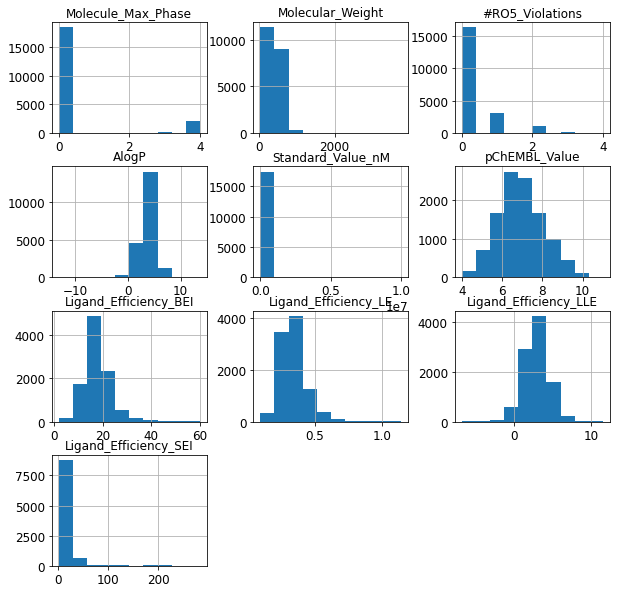

In [22]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

Standard_Type,% Ctrl,% Inhibition of Control Agonist Response (Mean n=2),% Inhibition of Control Specific Binding (Mean n=2),% of Control Agonist Response (Mean n=2),%max,AC50,Activation (% of control),Activity,Activity_index,Binding affinity,Bmax,D2 duration,Delta pKi,EC50,ED50,Effect,Efficacy,Emax,FC,IA,IC50,INH,Imax,Inhibition,Inhibition (% of control),Intinsic activity,Intrinsic activity,K,K0.5,KL,Ka,Kb,Kd,Kdiss,Ke,Ki,KiH,KiL,Log Ki,Max effect,Mean fold stimulation,Occ,Potency,RH,RH/RL,RL,Ratio,Ratio EC50,Ratio IC50,Ratio Ki,Selectivity,Selectivity Index,Stimulation,T1/2,TIME,deltalog(Tau/KA),log(Tau/KA),log(activity),logKi,nH,pD2,pKA,pKb,p[A50],p[A]50
count,8.000000,2.000000,8.000000,2.000000,24.000000,56.000000,1.0,444.000000,10.000000,10.000000,1.0,7.000000,3.000000,713.000000,16.000000,1.0,82.000000,381.000000,16.000000,5.000000,9.950000e+02,6.0,47.000000,967.000000,1.0,2.00000,169.000000,13.000000,1.0,1.0,54.000000,158.000000,86.000000,53.000000,2.000000,7.582000e+03,8.000000,1.0,18.000000,7.000000,1.00,3.000000,5.000000,3.000000,3.000000,3.000000,139.000000,18.000000,1.0,29.000000,1.0,10.000000,2.000000,58.000000,6.000000,3.000000,8.000000,72.000000,20.000000,25.000000,11.000000,29.000000,137.000000,1.0,2.00000
mean,98.937500,7.600000,14.612500,3.550000,87.481250,11491.946429,-1.0,35.297423,0.534000,81.600000,16.6,210.000000,-1.466667,6124.443411,14.731250,100.0,52.560691,56.558853,163.875000,56.200000,9.605196e+03,20000.0,55.422340,37.318568,67.0,35.50000,33.070976,0.291256,87.7,127.0,4.769074,12538.154722,1399.053442,0.908679,200.683333,8.705045e+03,9.852500,3420.0,2000.005000,71.571429,0.65,50.000000,10243.500000,44.833333,0.993333,55.750000,21.786408,62.750000,7.0,125.848276,62.0,1.661000,11.000000,0.122604,0.582225,-0.150000,5.720000,-0.746106,2.068050,0.886200,7.905455,7.115862,6.155043,4.0,9.27000
std,8.768603,1.414214,9.802104,0.636396,18.012283,26108.410590,NaN,106.519122,0.447119,89.864342,NaN,77.459667,0.585947,16766.790777,10.843168,NaN,40.652981,30.637323,442.991055,42.839234,2.753845e+04,0.0,47.766404,53.706693,NaN,2.12132,27.804223,0.450854,NaN,NaN,7.853853,31230.570708,3539.869731,0.330297,242.749758,1.723973e+05,19.770504,NaN,3321.148083,17.047553,NaN,26.457513,10545.118646,4.125631,0.198311,5.105144,52.353326,59.760859,NaN,336.227976,NaN,1.165337,15.556349,0.420625,0.245585,0.377492,12.181315,0.718537,0.164628,0.102157,0.985661,0.764302,1.344031,NaN,0.46669
min,90.000000,6.600000,1.800000,3.100000,41.000000,71.000000,-1.0,-97.000000,0.220000,5.000000,16.6,90.000000,-1.900000,0.010000,3.600000,100.0,0.030000,-6.260000,2.750000,3.000000,4.000000e-08,20000.0,-40.200000,-33.270000,67.0,34.00000,-0.600000,0.020000,87.7,127.0,1.000000,0.148000,0.030000,0.190000,29.033333,0.000000e+00,0.140000,3420.0,6.000000,49.000000,0.65,30.000000,11.200000,40.250000,0.777500,51.750000,-0.270000,2.000000,7.0,0.900000,62.0,-0.145000,0.000000,0.005000,0.160000,-0.550000,0.600000,-3.260000,1.640000,0.655000,6.500000,5.670000,3.590000,4.0,8.94000
25%,94.125000,7.100000,8.375000,3.325000,80.000000,223.000000,-1.0,1.000000,0.272500,27.750000,16.6,150.000000,-1.800000,32.700000,7.500000,100.0,14.250000,33.000000,14.625000,18.000000,7.039500e+01,20000.0,30.000000,10.000000,67.0,34.75000,11.000000,0.024000,87.7,127.0,1.690000,18.590000,2.166500,0.700000,114.858333,5.100000e+01,0.180000,3420.0,7.590000,59.000000,0.65,35.000000,198.600000,43.125000,0.906250,52.875000,1.050000,3.000000,7.0,5.100000,62.0,0.917500,5.500000,0.011170,0.475013,-0.325000,0.802500,-1.165000,2.022500,0.830000,7.400000,6.760000,5.095000,4.0,9.10500
50%,96.000000,7.600000,14.350000,3.550000,94.950000,505.000000,-1.0,18.250000,0.355000,45.500000,16.6,270.000000,-1.700000,320.000000,10.000000,100.0,46.000000,55.500000,32.000000,80.000000,1.000000e+03,20000.0,68.000000,32.000000,67.0,35.50000,30.000000,0.070000,87.7,127.0,3.300000,417.000000,20.940000,0.920000,200.683333,2.983000e+02,2.385000,3420.0,7.810000,75.000000,0.65,40.000000,8870.000000,46.000000,1.0350

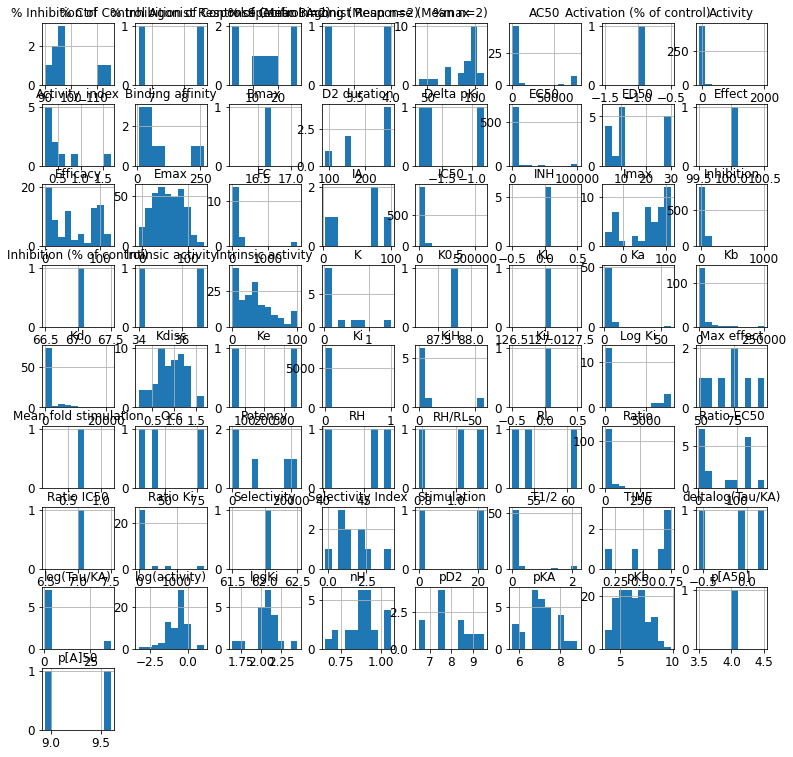

In [23]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

 What do you notice about the standard values?

Standard_Type,AC50,EC50,IC50,Kd,Ki
count,49.000000,514.00000,657.000000,86.000000,6501.000000
mean,6.358469,7.21173,6.706321,7.607791,6.802236
std,0.568055,1.18888,1.145667,1.399723,1.016266
min,4.250000,4.25000,4.030000,4.670000,4.000000
25%,6.150000,6.38125,5.800000,6.610000,6.110000
50%,6.450000,7.15750,6.700000,7.715000,6.730000
75%,6.750000,8.02050,7.570000,8.665000,7.450000
max,7.150000,11.00000,9.540000,10.520000,10.570000


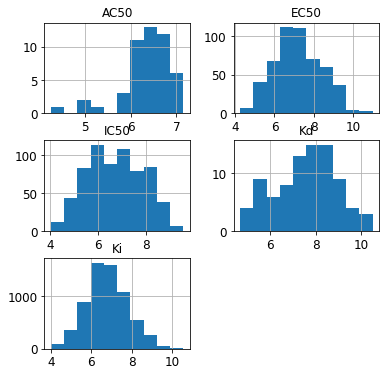

In [24]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way
- **Curation step:** add pValue column from raw measurements if it doesn't exist

In [25]:
dtc['pDTC_Value'] = np.where(dtc.standard_units == 'NM',
                                           -np.log10(dtc.standard_value/1000000000),
                                           dtc.standard_value)

standard_type,%MAX,%max,AC50,ACTIVITY,Activity,BINDING AFFINITY,BMAX,D2 DURATION,DELTA PKI,DISPLACEMENT,EC50,ED50,EFFECT,EFFICACY,EMAX,Efficacy,Emax,IA,IC50,ID50,IMAX,INH,INHIBITION,INTINSIC ACTIVITY,INTRINSIC ACTIVITY,Inhibition,Intrinsic activity,K0.5,KA,KB,KD,KI,KIH,KIL,KL,Kd,Ke,Ki,LOG KI,LOG(ACTIVITY),LOGKI,MAX EFFECT,NH,PD2,PKA,PKB,POTENCY,P[A50],P[A]50,RATIO,RATIO EC50,RATIO IC50,RATIO KI,RH,RH/RL,RL,Ratio,SELECTIVITY,SELECTIVITY INDEX,STIMULATION,T1/2,TOTAL BINDING INHIBITED
count,10.000000,14.000000,56.000000,345.000000,4.000000,10.000000,1.0,7.000000,3.000000,1.0,474.000000,16.000000,1.0,42.000000,164.000000,9.000000,14.000000,5.000000,7.600000e+02,3.000000,5.000000,6.0,530.000000,2.00000,165.000000,64.000000,1.0,1.0,1.0,54.000000,31.000000,6.228000e+03,1.0,1.0,1.0,1.00,2.000000,7.800000e+02,18.000000,8.000000,20.000000,7.000000,25.000000,11.000000,35.000000,33.000000,5.000000,1.0,2.00000,131.000000,8.000000,1.0,30.000000,3.000000,3.000000,3.000000,1.0,1.0,10.000000,2.000000,2.000000,4.000000
mean,76.000000,95.682143,11491.946429,40.588773,31.975000,81.600000,16.6,210.000000,-1.466667,70.0,6607.878755,14.731250,100.0,78.165873,63.533895,33.244444,63.671429,56.200000,5.713236e+03,255.333333,87.160000,20000.0,39.741490,35.50000,33.846182,38.213021,30.0,87.7,58.9,21666.987009,3139.997753,7.574197e+03,58.0,3420.0,127.0,0.16,200.683333,2.712027e+04,2000.005000,-0.096875,2.068500,71.571429,0.886200,7.905455,7.268857,6.881818,10243.500000,4.0,9.27000,23.765954,47.875000,7.0,122.786667,44.833333,0.993333,55.750000,8.5,62.0,1.661000,11.000000,2.085000,29.500000
std,21.197484,9.439761,26108.410590,119.135476,38.293635,89.864342,NaN,77.459667,0.585947,NaN,17255.159418,10.843168,NaN,36.601799,30.612269,7.275148,31.755034,42.839234,2.286250e+04,402.731093,17.373342,0.0,66.028686,2.12132,27.673966,29.579781,NaN,NaN,NaN,123152.275062,3960.171298,8.696538e+04,NaN,NaN,NaN,NaN,242.749758,5.059978e+05,3321.148083,0.420934,0.165665,17.047553,0.102157,0.985661,0.855791,0.718648,10545.118646,NaN,0.46669,54.931174,61.457157,NaN,330.805389,4.125631,0.198311,5.105144,NaN,NaN,1.165337,15.556349,0.120208,16.258331
min,41.000000,70.400000,71.000000,-97.000000,-5.000000,5.000000,16.6,90.000000,-1.900000,70.0,0.020000,3.600000,100.0,3.000000,-6.260000,22.900000,19.000000,3.000000,4.000000e-08,7.000000,58.900000,20000.0,-25.000000,34.00000,-0.600000,-5.400000,30.0,87.7,58.9,1.100000,0.030000,3.000000e-03,58.0,3420.0,127.0,0.16,29.033333,2.700000e-02,6.000000,-0.455000,1.640000,49.000000,0.655000,6.500000,5.670000,5.595000,11.200000,4.0,8.94000,0.100000,3.000000,7.0,0.900000,40.250000,0.777500,51.750000,8.5,62.0,-0.145000,0.000000,2.000000,15.000000
25%,60.250000,93.712500,223.000000,4.000000,3.175000,27.750000,16.6,150.000000,-1.800000,70.0,25.140000,7.500000,100.0,69.750000,36.600000,29.900000,32.775000,18.000000,1.000000e+02,23.000000,82.300000,20000.0,10.000000,34.75000,14.000000,11.650000,30.0,87.7,58.9,14.250000,53.391667,4.440000e+01,58.0,3420.0,127.0,0.16,114.858333,1.039325e+02,7.590000,-0.420000,2.022500,59.000000,0.830000,7.400000,6.792500,6.320000,198.600000,4.0,9.10500,1.601667,3.000000,7.0,5.125000,43.125000,0.906250,52.875000,8.5,62.0,0.917500,5.500000,2.042500,17.250000
50%,78.000000,98.275000,505.000000,24.000000,27.950000,45.500000,16.6,270.000000,-1.700000,70.0,281.500000,10.000000,100.0,95.500000,63.600000,31.100000,74.000000,80.000000,1.000000e+03,39.000000,94.600000,20000.0,35.000000,35.50000,30.000000,40.200000,30.0,87.7,58.9,152.050000,1659.950000,2.630150e+02,58.0,3420.0,127.0,0.16,200.683333,2.982300e+02,7.810000,-0.212500,2.085000,75.000000,0.890000,7.560000,7.190000,6.815000,8870.000000,4.0,9.27000,9.000000,15.000000,7.0,27.500000,46.000000,1.035000,54.000000,8.5,62.0,1.487500,11.000000,2.085000,26.500000
75%,95.250000,99.562500,1594.125000,52.380000,56.750000,90.000000,16.6,270.000000,-1.250000,70.0,10000.000000,30.000000,100.0,99.000000,87.100000,39.600000,88.275000,80.000000,1.000000e+04,379.500000,100.000000,20000.0,5

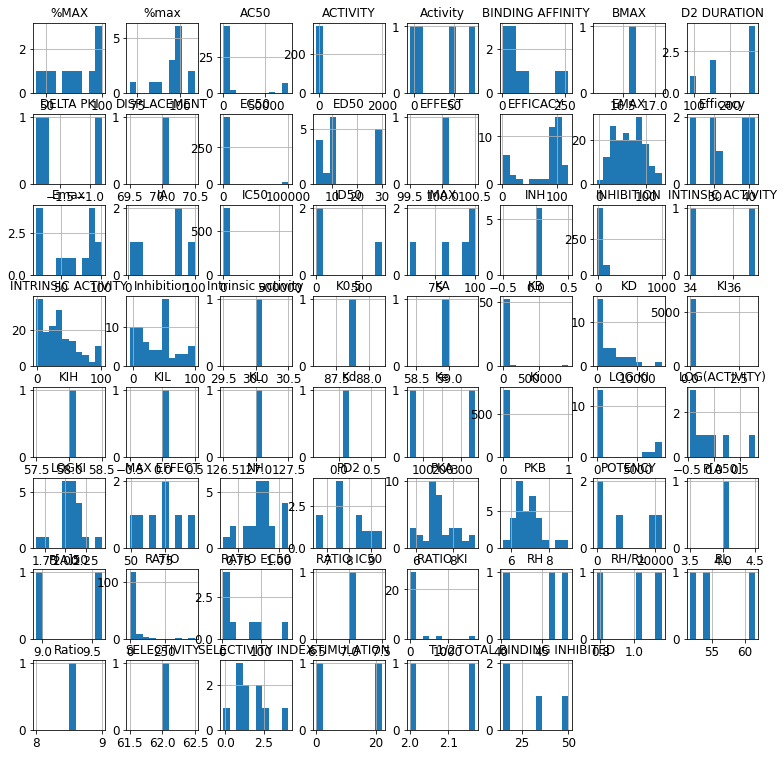

In [26]:
dtc_types=dtc.pivot_table(index = 'compound_id', columns = 'standard_type', values='standard_value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(13,13));

In [27]:
dtc=dtc.replace('None',np.nan)
dtc.columns

Index(['compound_id', 'standard_inchi_key', 'compound_name', 'synonym',
       'target_id', 'target_pref_name', 'gene_names', 'wildtype_or_mutant',
       'mutation_info', 'pubmed_id', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'activity_comment',
       'ep_action_mode', 'assay_format', 'assaytype', 'assay_subtype',
       'inhibitor_type', 'detection_tech', 'assay_cell_line',
       'compound_concentration_value', 'compound_concentration_value_unit',
       'substrate_type', 'substrate_relation', 'substrate_value',
       'substrate_units', 'assay_description', 'title', 'journal', 'doc_type',
       'annotation_comments', 'pDTC_Value'],
      dtype='object')

standard_type,%MAX,%max,AC50,ACTIVITY,Activity,BINDING AFFINITY,BMAX,D2 DURATION,DELTA PKI,DISPLACEMENT,EC50,ED50,EFFECT,EFFICACY,EMAX,Efficacy,Emax,IA,IC50,ID50,IMAX,INH,INHIBITION,INTINSIC ACTIVITY,INTRINSIC ACTIVITY,Inhibition,Intrinsic activity,K0.5,KA,KB,KD,KI,KIH,KIL,KL,Kd,Ke,Ki,LOG KI,LOG(ACTIVITY),LOGKI,MAX EFFECT,NH,PD2,PKA,PKB,POTENCY,P[A50],P[A]50,RATIO,RATIO EC50,RATIO IC50,RATIO KI,RH,RH/RL,RL,Ratio,SELECTIVITY,SELECTIVITY INDEX,STIMULATION,T1/2,TOTAL BINDING INHIBITED
count,10.000000,14.000000,56.000000,345.000000,4.000000,10.000000,1.0,7.000000,3.000000,1.0,474.000000,16.000000,1.0,42.000000,164.000000,9.000000,14.000000,5.000000,760.000000,3.000000,5.000000,6.00000,530.000000,2.00000,165.000000,64.000000,1.0,1.000,1.000000,54.000000,31.000000,6228.000000,1.000000,1.000000,1.000000,1.00000,2.000000,780.000000,18.000000,8.000000,20.000000,7.000000,25.000000,11.000000,35.000000,33.000000,5.000000,1.0,2.00000,131.000000,8.000000,1.0,30.000000,3.000000,3.000000,3.000000,1.0,1.0,10.000000,2.000000,2.000000,4.000000
mean,76.000000,95.682143,6.078847,32.255196,31.975000,7.335742,16.6,210.000000,-1.466667,70.0,10.623129,14.731250,100.0,78.165873,63.533895,33.244444,63.671429,56.200000,6.206713,7.235502,87.160000,4.69897,39.741490,35.50000,33.846182,38.213021,30.0,7.057,7.229885,6.852387,6.589811,7.350979,7.236572,5.465974,6.896196,9.79588,6.989077,6.531572,7.290595,-0.096875,2.068500,71.571429,0.886200,7.905455,7.268857,6.881818,5.811807,4.0,9.27000,23.765954,47.875000,7.0,122.786667,44.833333,0.993333,55.750000,8.5,62.0,1.661000,11.000000,2.085000,29.500000
std,21.197484,9.439761,0.918216,34.697986,38.293635,0.521805,NaN,77.459667,0.585947,NaN,60.192809,10.843168,NaN,36.601799,30.612269,7.275148,31.755034,42.839234,1.401824,1.017267,17.373342,0.00000,66.028686,2.12132,27.673966,29.579781,NaN,NaN,NaN,1.353286,1.422575,27.059768,NaN,NaN,NaN,NaN,0.791809,0.780609,1.369666,0.420934,0.165665,17.047553,0.102157,0.985661,0.855791,0.718648,1.459568,NaN,0.46669,54.931174,61.457157,NaN,330.805389,4.125631,0.198311,5.105144,NaN,NaN,1.165337,15.556349,0.120208,16.258331
min,41.000000,70.400000,4.113509,-97.000000,-5.000000,6.576754,16.6,90.000000,-1.900000,70.0,4.000000,3.600000,100.0,3.000000,-6.260000,22.900000,19.000000,3.000000,3.236572,6.142668,58.900000,4.69897,-25.000000,34.00000,-0.600000,-5.400000,30.0,7.057,7.229885,3.045757,4.795880,2.850165,7.236572,5.465974,6.896196,9.79588,6.429183,2.000000,5.091515,-0.455000,1.640000,49.000000,0.655000,6.500000,5.670000,5.595000,4.652079,4.0,8.94000,0.100000,3.000000,7.0,0.900000,40.250000,0.777500,51.750000,8.5,62.0,-0.145000,0.000000,2.000000,15.000000
25%,60.250000,93.712500,5.983091,4.000000,3.175000,7.057790,16.6,150.000000,-1.800000,70.0,5.000000,7.500000,100.0,69.750000,36.600000,29.900000,32.775000,18.000000,5.000000,6.775801,82.300000,4.69897,10.000000,34.75000,14.000000,11.650000,30.0,7.057,7.229885,6.133303,5.609725,5.948462,7.236572,5.465974,6.896196,9.79588,6.709130,6.130871,5.906203,-0.420000,2.022500,59.000000,0.830000,7.400000,6.792500,6.320000,4.702078,4.0,9.10500,1.601667,3.000000,7.0,5.125000,43.125000,0.906250,52.875000,8.5,62.0,0.917500,5.500000,2.042500,17.250000
50%,78.000000,98.275000,6.423633,24.000000,27.950000,7.343277,16.6,270.000000,-1.700000,70.0,6.612669,10.000000,100.0,95.500000,63.600000,31.100000,74.000000,80.000000,6.000000,7.408935,94.600000,4.69897,35.000000,35.50000,30.000000,40.200000,30.0,7.057,7.229885,6.935287,6.109998,6.645053,7.236572,5.465974,6.896196,9.79588,6.989077,6.551420,8.107349,-0.212500,2.085000,75.000000,0.890000,7.560000,7.190000,6.815000,5.052076,4.0,9.27000,9.000000,15.000000,7.0,27.500000,46.000000,1.035000,54.000000,8.5,62.0,1.487500,11.000000,2.085000,26.500000
75%,95.250000,99.562500,6.675195,50.000000,56.750000,7.562469,16.6,270.000000,-1.250000,70.0,7.679661,30.000000,100.0,99.000000,87.100000,39.600000,88.275000,80.000000,7.031589,7.781919,100.000000,4.69897,50.000000,36.25000,50.000000,50.000000,30.0,7.057,7.229885,7.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f17359650>,
      dtype=object)

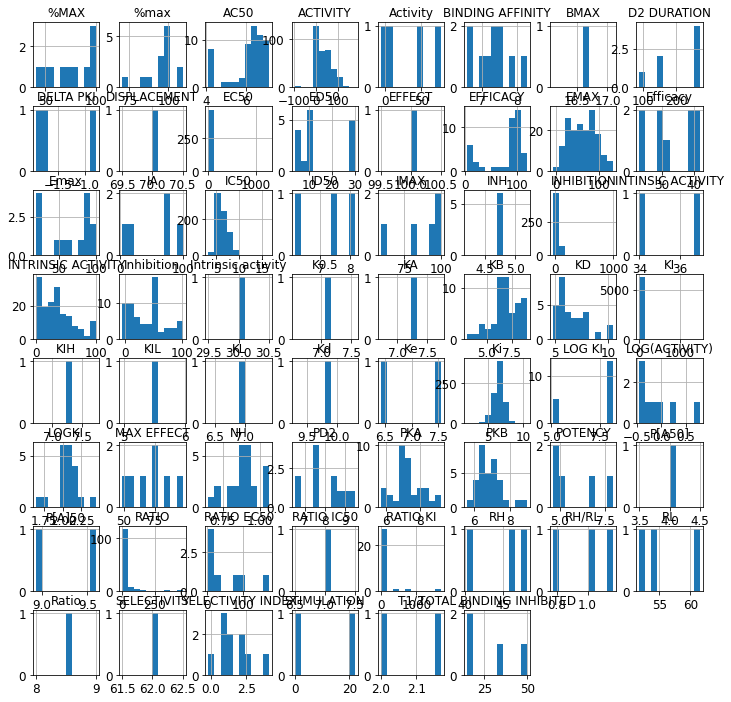

In [28]:
dtc_types=dtc.pivot_table(index = 'compound_id', columns = 'standard_type', values='pDTC_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(12,12))

,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,76636.0,1046.000000,7.663600e+04,76636.0,76636.0
mean,1813.0,6.824057,4.845304e+05,9606.0,1171.0
std,0.0,1.158742,4.114256e+04,0.0,0.0
min,1813.0,2.880000,5.259600e+04,9606.0,1171.0
25%,1813.0,6.030000,4.853580e+05,9606.0,1171.0
50%,1813.0,6.715000,4.853580e+05,9606.0,1171.0
75%,1813.0,7.600000,4.853580e+05,9606.0,1171.0
max,1813.0,15.000000,1.369049e+06,9606.0,1171.0


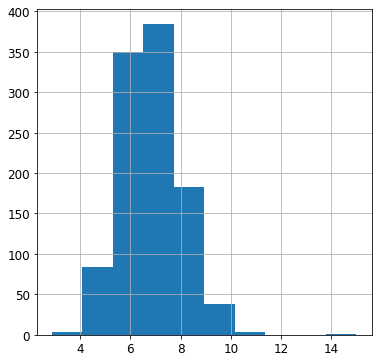

In [29]:
display(excape.describe())
excape.pXC50.hist(figsize=(6,6))

In [30]:
dtc.iloc[0:3, 0:5]

,compound_id,standard_inchi_key,compound_name,synonym,target_id
0,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416
1,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416
2,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416


## EDA & Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
dtc.head()

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value
0,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,1840645.0,KI,=,0.09,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.045757
1,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,1840645.0,KI,=,2.10,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.677781
2,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,2531826.0,KI,=,0.04,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.397940
3,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,2869639.0,KI,=,0.31,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.508638
4,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,2869639.0,KI,=,0.92,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.036212


In [33]:

pdtc50 = dtc.loc[(dtc['standard_type'] == 'IC50') | (dtc['standard_type'] =='EC50'),"pDTC_Value"]
pdtc50

22            NaN
26       6.509999
27       6.507240
34       6.301030
39            NaN
           ...   
17527    5.443697
17528    7.259637
17529    7.457175
17583         NaN
17587         NaN
Name: pDTC_Value, Length: 2454, dtype: float64

(2.0, 20.0)

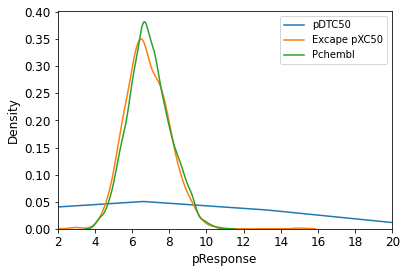

In [34]:
sns.kdeplot(pdtc50, label = 'pDTC50')
sns.kdeplot(excape['pXC50'], label='Excape pXC50')
sns.kdeplot(chembl['pChEMBL_Value'], label='Pchembl')
plt.xlabel('pResponse')
plt.legend()
plt.xlim([2, 20])

## Exercise: analyze & discuss
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

# EDA: Compounds
- make sure smiles strings exist since that's what AMPL uses
- compare compounds in each dataset
- featurize with ECFP fingerprints
- examine diversity of compound set

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets/excel or from the LHS folder menu, right-click on the "HTR3A_DTC.csv" file to download it to your computer and open the file with Excel. 
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi  (use highlight and click on "Follow-link" option to open the link in your browser)
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

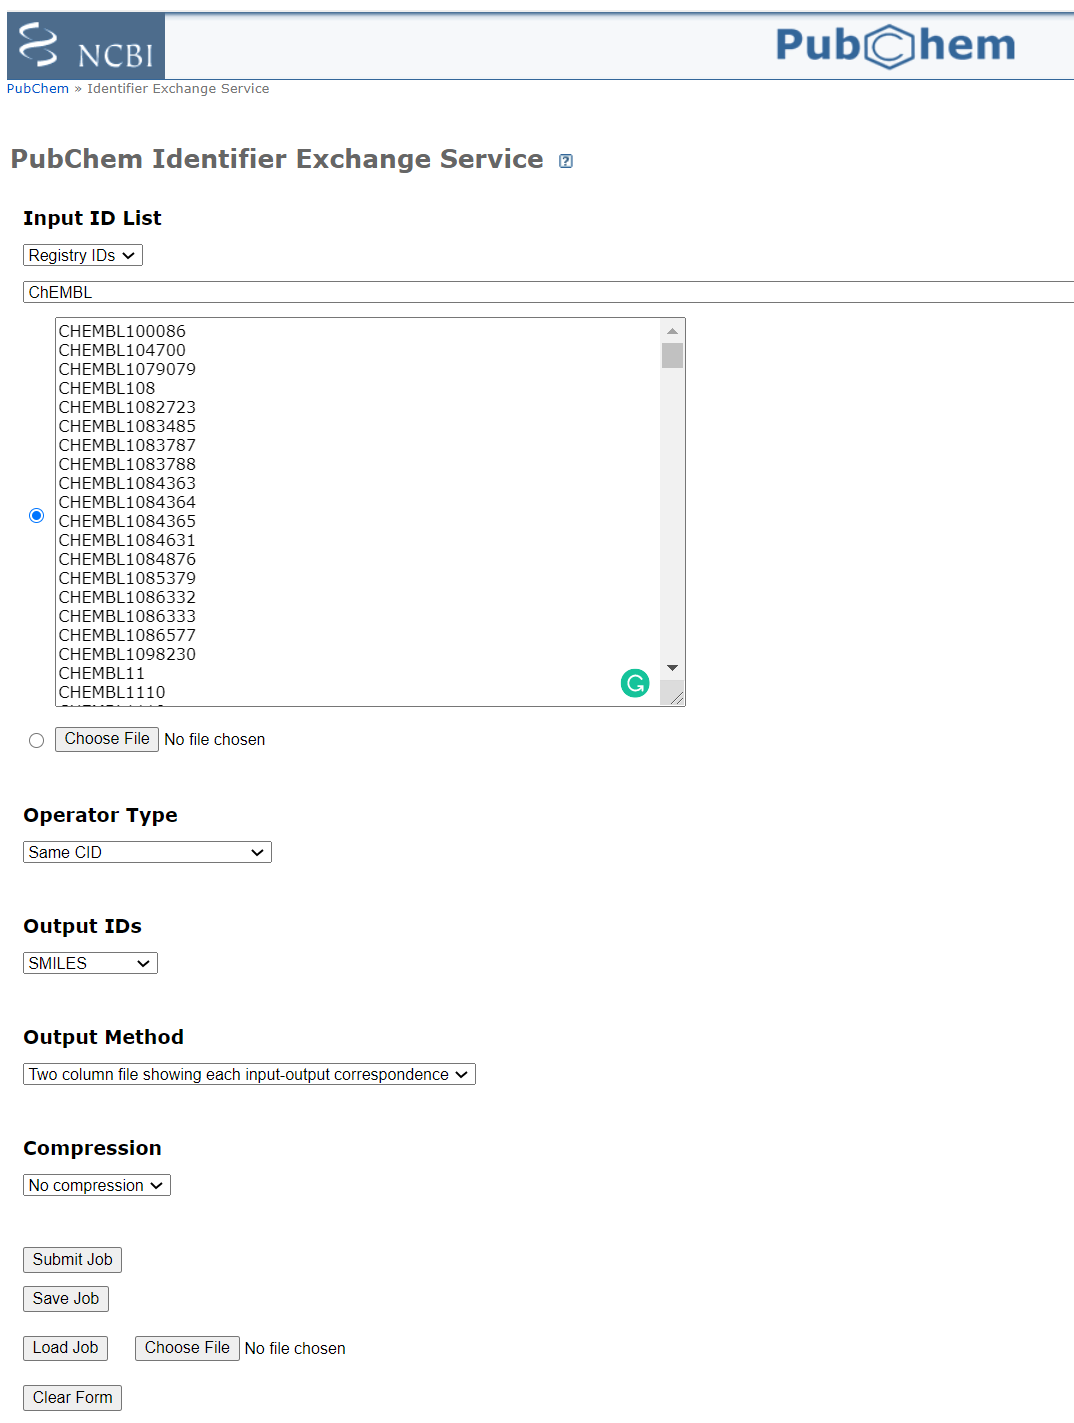

In [96]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/Img/PubChemCIDExchange.png", 
      width = 900, height = 900)

## Note, the output from PubChem Identifier Exchange Service can be uploaded into the left hand window of COLAB by dragging and dropping the file. In my case the output file is, `3897649727682520004.txt`

In my case, I have saved the file in Github and I am uploading it. 

In [35]:
! wget https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/3109111863811388882.txt

--2021-04-28 02:18:10--  https://raw.githubusercontent.com/zp2226/E4511-2021-Zhanbo/main/3109111863811388882.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1196081 (1.1M) [text/plain]
Saving to: ‘3109111863811388882.txt’

3109111863811388882 100%[===================>]   1.14M  --.-KB/s    in 0.06s   

2021-04-28 02:18:10 (18.0 MB/s) - ‘3109111863811388882.txt’ saved [1196081/1196081]



In [36]:
# open file from pubchem ID exchange service
dtc_smiles = pd.read_csv("3109111863811388882.txt", sep="\t",header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
1,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
2,CHEMBL100203,CC1=C2C3=C(CSC2=C(S1)C)C=NN3C
3,CHEMBL100264,C1COCCN1C2=NC3=CC=CC=C3C(=N2)NC4=CC=C(C=C4)Cl
4,CHEMBL100454,CN1CCN(CC1)C2=NC3=CC=CC=C3NC4=C2C=C(S4)CO


In [37]:
dtc.head()

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value
0,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,1840645.0,KI,=,0.09,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.045757
1,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,1840645.0,KI,=,2.10,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.677781
2,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,2531826.0,KI,=,0.04,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.397940
3,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,2869639.0,KI,=,0.31,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.508638
4,CHEMBL8946,AADCDMQTJNYOSS-LBPRGKRZSA-N,ETICLOPRIDE,NaN,P14416,DOPAMINE D2 RECEPTOR,DRD2,NaN,NaN,2869639.0,KI,=,0.92,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.036212


In [38]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['compound_id'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [39]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['compound_id'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 186
No SMILES from ChemblID in DTC: 346


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [ ]:
# try it yourself here

In [40]:
inchikey = dtc.loc[dtc['SMILES'].isna(),'standard_inchi_key']
inchikey[inchikey.isna()==False].values

array(['ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'ABZSPJVXTTUFAA-UHFFFAOYSA-

In [41]:
print("No ChemblID in DTC:", sum(dtc['compound_id'].isna()))
print("No SMILES from ChemblID in DTC:", sum(dtc.SMILES.isna()))

No ChemblID in DTC: 186
No SMILES from ChemblID in DTC: 346


## EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

In [42]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

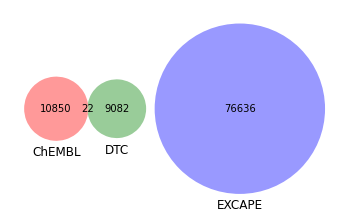

In [43]:
# overlaps from SMILES strings
venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists

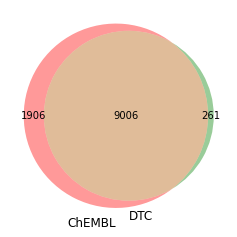

In [44]:
venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.compound_id)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without base smiles

In [45]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

20833
10872
10790


In [46]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
90,CHEMBL414804,OXALIPLATIN,4.0,NaN,NaN,NaN,OXALIPLATIN,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,
277,CHEMBL1458880,CADMIUM DICHLORIDE,0.0,183.32,NaN,NaN,CADMIUM CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,
493,CHEMBL364516,N-{4-[4-(2-methoxyphenyl)piperazin-1-yl]butyl}...,0.0,467.35,NaN,NaN,1a,NaN,Ki,'=',78.00,nM,7.11,NaN,NaN,UO_0000065,15.21,NaN,NaN,NaN,False,CHEMBL829637,Inhibition of [3H]spiperone binding to human d...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,ovary,NaN,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1139523,1,Scientific Literature,J. Med. Chem.,2005.0,NaN,NaN,78.00,
674,CHEMBL194555,Fe complex,0.0,506.21,NaN,NaN,1b,NaN,Ki,'=',31.00,nM,7.51,NaN,NaN,UO_0000065,14.83,NaN,NaN,NaN,False,CHEMBL829061,Inhibition of [3H]spiperone binding to human d...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,ovary,NaN,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1139523,1,Scientific Literature,J. Med. Chem.,2005.0,NaN,NaN,31.00,
685,CHEMBL1200693,MANGANESE CHLORIDE,4.0,125.84,NaN,NaN,MANGANESE (II) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18412,CHEMBL3559671,POLYVINYL ALCOHOL,4.0,NaN,NaN,NaN,POLYVINYL ALCOHOL,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,
19065,CHEMBL1909074,POLYVINYLPYRROLIDONE,0.0,NaN,NaN,NaN,POLYVINYLPYRROLIDONE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,
19314,CHEMBL4532510,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Inhibition,'=',2.86,%,NaN,N

In [47]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
90,CHEMBL414804,OXALIPLATIN,4.0,NaN,NaN,NaN,OXALIPLATIN,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,NaN
277,CHEMBL1458880,CADMIUM DICHLORIDE,0.0,183.32,NaN,NaN,CADMIUM CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,NaN
493,CHEMBL364516,N-{4-[4-(2-methoxyphenyl)piperazin-1-yl]butyl}...,0.0,467.35,NaN,NaN,1a,NaN,Ki,'=',78.00,nM,7.11,NaN,NaN,UO_0000065,15.21,NaN,NaN,NaN,False,CHEMBL829637,Inhibition of [3H]spiperone binding to human d...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,ovary,NaN,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1139523,1,Scientific Literature,J. Med. Chem.,2005.0,NaN,NaN,78.00,NaN
674,CHEMBL194555,Fe complex,0.0,506.21,NaN,NaN,1b,NaN,Ki,'=',31.00,nM,7.51,NaN,NaN,UO_0000065,14.83,NaN,NaN,NaN,False,CHEMBL829061,Inhibition of [3H]spiperone binding to human d...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,ovary,NaN,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1139523,1,Scientific Literature,J. Med. Chem.,2005.0,NaN,NaN,31.00,NaN
685,CHEMBL1200693,MANGANESE CHLORIDE,4.0,125.84,NaN,NaN,MANGANESE (II) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18412,CHEMBL3559671,POLYVINYL ALCOHOL,4.0,NaN,NaN,NaN,POLYVINYL ALCOHOL,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,NaN
19065,CHEMBL1909074,POLYVINYLPYRROLIDONE,0.0,NaN,NaN,NaN,POLYVINYLPYRROLIDONE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909140,DRUGMATRIX: Dopamine D2L radioligand binding (...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO,Membrane,NaN,NaN,NaN,CHEMBL217,Dopamine D2 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308072,NaN,NaN,NaN
19314,CHEMBL4532510,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Inhibi

In [48]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles


In [49]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [50]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(curate_data.base_smiles_from_smiles)
print(len(excape.SMILES))
print(len(excape.SMILES.unique()))
print(len(excape.base_rdkit_smiles.unique()))

76636
76636
76620


In [51]:
excape[excape.base_rdkit_smiles.duplicated(keep=False)].sort_values('base_rdkit_smiles') 

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
4220,BBBNALDQWJNLRR-UHFFFAOYNA-N,5914201,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,S1C(C(N(CCC)C1=S)=N(O)=CC2=CC=CN=C2)(C)C,
60411,DZMCCNYZTXNFFO-UHFFFAOYNA-N,661292,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,ON=12CCN(CC1)C=3C2=CC=CC3,
58622,FAHXXTAUWSMEJI-UHFFFAOYNA-N,5289890,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,ClC1=C(C=N(O)=C2SC(=S)N(C2(C)C)C)C(F)=CC=C1,
55188,DGRUHHXSHXSBJG-UHFFFAOYNA-N,5389054,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,S1C(=N(O)=CC=2OC=CC2)C(N(C1=S)C)(C)C,
50176,FPQPXTJEDGZLLE-UHFFFAOYNA-N,13895170,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,ON1(C=2C3=C(CC1)C=C4OCOC4=C3C5=C(C2)C=C(OC)C=C5)C,
43062,DTOSUPMMNCILOM-UHFFFAOYNA-N,5923263,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,S1C(=N(O)=CC2=C(OC)C=CC=C2)C(N(C1=S)C)(C)C,
68887,FEKVENOWLIITGZ-UHFFFAOYNA-N,5289892,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,S1C(C(N(C1=S)C2=CC=CC=C2)=N(O)=CC3=CC(N(=O)=O)...,
35404,AIXSXRYJXFDHLG-UHFFFAOYNA-N,9497288,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,ON(=CC1=C(C(=C(C(=C1C)C)C)C)C)=C,
31747,SSVGMIDDGMGJED-DCYBUDGMNA-N,2540784,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,O(CC(=O)[NH2]C1=[C]C=2N=C(O)NC2C=C1)C(=O)C3=CC...,
28303,DAPCKNJKGASBHF-UHFFFAOYNA-N,5389047,1813,N,NaN,pubchem_screening,485358,9606,DRD2,1171,S1C(=N(O)=CC=2SC=CC2)C(N(C1=S)C)(C)C,


In [52]:
excape=excape.replace('',np.nan)
excape=excape[~excape.base_rdkit_smiles.isna()]

In [53]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
dtc=dtc.replace('',np.nan)
dtc=dtc[~dtc.base_rdkit_smiles.isna()]
print(len(dtc.SMILES))
print(len(dtc.SMILES.unique()))
print(len(dtc.base_rdkit_smiles.unique()))

17244
9103
9024


In [54]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
print(len(dtc.SMILES))
print(len(dtc.SMILES.unique()))
print(len(dtc.base_rdkit_smiles.unique()))

17244
9103
9024


In [55]:

dtc[dtc.base_rdkit_smiles=='']

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value,SMILES,base_rdkit_smiles


In [56]:

dtc=dtc.replace('',np.nan)
dtc[dtc.base_rdkit_smiles.isna()]

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value,SMILES,base_rdkit_smiles


In [57]:
dtc=dtc[~dtc.base_rdkit_smiles.isna()]

## **Curation step:** Save standardized datasets

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
chembl.to_csv("/content/drive/MyDrive/DRD2_ChEMBL_SMILES.csv")
dtc.to_csv("/content/drive/MyDrive/DRD2_DTC_SMILES.csv")
excape.to_csv("/content/drive/MyDrive/DRD2_Excape_SMILES.csv")

## Exercise: examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

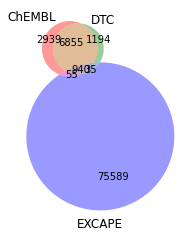

In [58]:
venn3([set(chembl.base_rdkit_smiles),
           set(dtc.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

## EDA: Examine compound diversity

In [62]:
#import diversity_plots as dp
sns.set_context('poster')

In [64]:

from rdkit import Chem
import seaborn as sns
from atomsci.ddm.pipeline import diversity_plots as dp

from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat

import umap
from scipy.stats.kde import gaussian_kde
from scipy.cluster.hierarchy import linkage

import matplotlib.pyplot as plt

ndist_max = 1000000

def plot_tani_dist_distr(dataset, smiles_col, dataset_name, **metric_kwargs):
    """
    Generate a density plot showing the distribution of distances between ecfp feature
    vectors, using the tanimoto metric.
    """
    # log = logging.getLogger('ATOM')
    num_cmpds = len(dataset)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    # log.warning("Starting distance matrix calculation for %d compounds" % num_cmpds)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    smiles_arr1 = dataset[smiles_col].values
    mols1 = [Chem.MolFromSmiles(s) for s in smiles_arr1]
    fprints1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in mols1]
    dists = GetTanimotoDistMat(fprints1)

    # log.warning("Finished calculation of %d distances" % len(dists))

    if len(dists) > ndist_max:
        # Sample a subset of the distances so KDE doesn't take so long
        dist_sample = np.random.choice(dists, size=ndist_max)
    else:
        dist_sample = dists

    dist_pdf = gaussian_kde(dist_sample)
    x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
    y_plt = dist_pdf(x_plt)
    fig, ax = plt.subplots(figsize=(8.0,8.0))
    ax.plot(x_plt, y_plt)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
                  dataset_name, dist_metric, feat_type))
    return dists
sns.set_context('poster')

In [ ]:
sns.set_context('poster')
plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/DRD2_ChEMBL_SMILES.csv', 
                   datastore=False, id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')

## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?